# Предсказание выбросов ГТД

## Техническое задание:

Прогнозирование выбросов CO и NOx по характеристикам ГТД

# Импорт библиотек

Стандартные библиотеки

In [62]:
import os
import sys
import pickle
from tqdm import tqdm
from colorama import Fore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score,mean_squared_error

import tensorflow as tf
import torch

In [2]:
for lib in (pd, np, tf, torch):
    print(f'{lib.__name__}: {lib.__version__}')

pandas: 2.2.2
numpy: 1.26.4
tensorflow: 2.16.1
torch: 2.3.0+cpu


Частные библиотеки

In [3]:
sys.path.append('D:/Programming/Python/scripts')

In [136]:
from pandas_tools import DataFrame
#from ml_tools import SCALERS, DataFrame, Model, Stacking, Bagging, Boosting
from tensorflow_tools import training_plot, predictions_plot

# Определение констант

# Data Engeneering

## Импорт и визуализация исходных данных

In [5]:
for root, dirs, files in os.walk('datas'):
    if files:
        print('root: ', Fore.RED + root + Fore.RESET)
        print('directories: ', Fore.YELLOW + ', '.join(dirs) + Fore.RESET)
        print('files: ' + Fore.GREEN + ', '.join(files) + Fore.RESET)
        print()

root:  datas\external
directories:  
files: gte_emissions.csv



In [6]:
df = pd.read_csv('datas/external/gte_emissions.csv')
df = DataFrame(df)

In [7]:
df

AT       AP      AH    AFDP    GTEP      TIT     TAT     TEY  \
0      277.7378  101.870  83.675  3.5758  239.79  1359.35  822.98  134.67   
1      277.4432  101.830  84.235  3.5709  239.51  1359.25  823.20  134.67   
2      277.0545  101.840  84.858  3.5828  239.90  1359.65  823.34  135.10   
3      276.8936  101.830  85.434  3.5808  239.11  1359.65  823.32  135.03   
4      276.9016  101.780  85.182  3.5781  239.17  1359.05  823.15  134.67   
...         ...      ...     ...     ...     ...      ...     ...     ...   
36728  276.7768  102.850  93.200  3.1661  190.87  1310.15  814.74  109.08   
36729  277.3174  102.859  94.036  3.1923  190.16  1310.75  815.43  108.79   
36730  278.6320  102.850  95.219  3.3128  188.57  1311.15  816.63  107.81   
36731  279.0337  102.870  94.200  3.9831  235.63  1350.05  823.26  131.41   
36732  279.1892  102.880  94.547  3.8752  225.24  1341.05  821.38  125.41   

          CDP        CO      NOX  
0      1189.8   0.32663   81.952  
1      1189.2   0.44784   82.377  
2      1204.2   0.45144   83.776  
3      1199.0   0.23107   82.505  
4      1191.0   0.26747   82.028  
...       ...       ...      ...  
36728  1041.1  10.99300   89.172  
36729  1034.4  11.14400   88.849  
36730  1046.2  11.41400   96.147  
36731  1177.1   3.31340   64.738  
36732  1146.2  11.98100  109.240  

[36733 rows x 11 columns]

Данные содержат 36733 экземпляров 11 измерений датчиков, агрегированных за один час (посредством среднего значения или суммы) газовой турбины. 
Набор данных включает параметры газовой турбины такие как температура на входе в турбину и давление нагнетания компрессора, а также параметры окружающей среды.

Пояснения к сенсорным измерениям и их краткая статистика приведены ниже.

`сокр.` [Единица измерения] = Переменная 

- `AT` [K] = Температура окружающей среды
- `AP` [кПа] = Давление окружающей среды 
- `AH` [%] = Влажность окружающей среды  

- `AFDP` [кПа] = Потеря давления в воздушном фильтре 
- `CDP` [кПА] = Давление после компрессора
- `GTEP` [кПа] = Давление выхлопа газовой турбины 

- `TIT` [K] = Температура перед турбину 
- `TAT` [K] = Температура после турбины  

- `TEY` [МВт*ч] = Энергетический выход турбины 
- `CO` [мг/м^3] = Оксид углерода 
- `NOx` [мг/м^3] = Оксиды азота 

## Предварительная обработка

Переименование

- _i = inlet
- _o = outlet

In [8]:
df.rename(columns={'AT': 'T_atm', 'AP': 'P_atm', 'AH': 'H_atm', # НУ
                   'AFDP': 'dP_inlet',
                   'TIT': 'T_turbine_i', 'TAT': 'T_turbine_o',
                   'CDP': 'P_compressor_o',
                   'GTEP': 'P_outlet_o',
                   'TEY': 'A',
                   'NOX': 'NOx'},
          inplace=True)

In [9]:
df.columns

Index(['T_atm', 'P_atm', 'H_atm', 'dP_inlet', 'P_outlet_o', 'T_turbine_i',
       'T_turbine_o', 'A', 'P_compressor_o', 'CO', 'NOx'],
      dtype='object')

In [34]:
targets = ('CO', 'NOx')

## Обрботка типов данных

In [10]:
df.info(memory_usage='deep')

<class 'pandas_tools.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   T_atm           36733 non-null  float64
 1   P_atm           36733 non-null  float64
 2   H_atm           36733 non-null  float64
 3   dP_inlet        36733 non-null  float64
 4   P_outlet_o      36733 non-null  float64
 5   T_turbine_i     36733 non-null  float64
 6   T_turbine_o     36733 non-null  float64
 7   A               36733 non-null  float64
 8   P_compressor_o  36733 non-null  float64
 9   CO              36733 non-null  float64
 10  NOx             36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


In [164]:
categorials = df.select_dtypes(['object']).columns.to_list()
print(f'Категориальные признаки: {categorials}')

Категориальные признаки: []


In [165]:
numeric = df.select_dtypes(['int', 'float']).columns.to_list()
print(f'Числовые признаки: {numeric}')

Числовые признаки: ['T_atm', 'P_atm', 'H_atm', 'T_turbine_i', 'T_turbine_o', 'CO', 'NOx', 'sigma_inlet', 'pi_compressor']


### Обработка локальных пустот и дубликатов

In [11]:
df.isna().sum()

T_atm             0
P_atm             0
H_atm             0
dP_inlet          0
P_outlet_o        0
T_turbine_i       0
T_turbine_o       0
A                 0
P_compressor_o    0
CO                0
NOx               0
dtype: int64

In [13]:
df[df.duplicated()].shape

(7, 11)

In [14]:
df.drop_duplicates(ignore_index=True, inplace=True)

In [15]:
df[df.duplicated()].shape

(0, 11)

## Выделение признаков

Проверка на отрицательную температуру

In [16]:
df[df['T_atm'] <= 273.15]

T_atm    P_atm   H_atm  dP_inlet  P_outlet_o  T_turbine_i  \
29360  272.93402  102.670  51.978    2.5301      194.38      1323.55   
29374  273.06790  102.370  64.949    2.8720      238.98      1348.55   
29375  272.63219  102.330  69.287    2.8670      236.92      1348.25   
29376  272.15140  102.280  70.710    2.9023      234.62      1348.25   
29377  272.06590  102.230  70.733    2.8280      226.04      1345.05   
...          ...      ...     ...       ...         ...          ...   
29511  267.26530  103.359  66.920    4.2815      362.18      1373.15   
29512  267.10790  103.330  68.008    4.4238      375.05      1373.05   
29513  267.52820  103.320  66.772    4.3915      371.05      1373.05   
29514  268.58360  103.280  69.383    4.1850      350.72      1373.25   
29515  271.13540  103.209  68.559    4.1822      350.12      1373.05   

       T_turbine_o       A  P_compressor_o      CO      NOx  
29360       819.86  115.46          1076.7  7.0983  116.960  
29374       823.36  133.77          1173.7  3.7902   85.485  
29375       823.49  133.77          1173.4  3.3021   85.342  
29376       823.45  133.03          1171.0  1.8773   84.164  
29377       823.46  130.41          1152.6  1.7751   83.696  
...            ...     ...             ...     ...      ...  
29511       793.39  176.55          1489.1  1.2721   56.124  
29512       789.19  179.50          1515.9  1.5776   55.572  
29513       790.87  177.91          1502.9  1.6697   56.386  
29514       797.70  173.05          1462.6  1.4528   59.496  
29515       799.30  170.26          1449.7  1.7187   50.349  

[62 rows x 11 columns]

In [17]:
# коэф. сохранения давления в входном устройстве
df['sigma_inlet'] = 1 - df['dP_inlet'] / df['P_atm']

# далвение перед компрессором
df['P_compressor_i'] = df['P_atm'] - df['dP_inlet']

# степень повышения температуры турбины
df['theta_turbine'] = df['T_turbine_i'] / df['T_turbine_o']

# степени повышения/понижения давления
df['pi_compressor'] = df['P_compressor_o'] / (df['P_atm'] - df['dP_inlet'])
df['pi_turbine'] = df['P_compressor_o'] / df['P_outlet_o']
df['pi_outlet'] = df['P_outlet_o'] / df['P_atm']

In [22]:
df.head(8).T

0            1            2            3  \
T_atm            277.737800   277.443200   277.054500   276.893600   
P_atm            101.870000   101.830000   101.840000   101.830000   
H_atm             83.675000    84.235000    84.858000    85.434000   
dP_inlet           3.575800     3.570900     3.582800     3.580800   
P_outlet_o       239.790000   239.510000   239.900000   239.110000   
T_turbine_i     1359.350000  1359.250000  1359.650000  1359.650000   
T_turbine_o      822.980000   823.200000   823.340000   823.320000   
A                134.670000   134.670000   135.100000   135.030000   
P_compressor_o  1189.800000  1189.200000  1204.200000  1199.000000   
CO                 0.326630     0.447840     0.451440     0.231070   
NOx               81.952000    82.377000    83.776000    82.505000   
sigma_inlet        0.964898     0.964933     0.964819     0.964836   
P_compressor_i    98.294200    98.259100    98.257200    98.249200   
theta_turbine      1.651741     1.651178     1.651383     1.651424   
pi_compressor     12.104478    12.102696    12.255590    12.203662   
pi_turbine         4.961842     4.965137     5.019591     5.014429   
pi_outlet          2.353882     2.352057     2.355656     2.348129   

                          4            5            6            7  
T_atm            276.901600   277.035800   276.819700   276.739200  
P_atm            101.780000   101.770000   101.800000   101.820000  
H_atm             85.182000    83.946000    84.114000    83.867000  
dP_inlet           3.578100     3.582400     3.580400     3.577700  
P_outlet_o       239.170000   239.030000   238.890000   238.760000  
T_turbine_i     1359.050000  1359.150000  1359.050000  1359.150000  
T_turbine_o      823.150000   823.130000   823.190000   823.030000  
A                134.670000   134.670000   134.680000   134.660000  
P_compressor_o  1191.000000  1186.800000  1187.700000  1189.300000  
CO                 0.267470     0.234730     0.444120     0.799960  
NOx               82.028000    81.748000    84.592000    84.193000  
sigma_inlet        0.964845     0.964799     0.964829     0.964863  
P_compressor_i    98.201900    98.187600    98.219600    98.242300  
theta_turbine      1.651036     1.651197     1.650955     1.651398  
pi_compressor     12.128075    12.087066    12.092291    12.105783  
pi_turbine         4.979722     4.965067     4.971744     4.981153  
pi_outlet          2.349872     2.348728     2.346660     2.344922

## Обработка выбросов

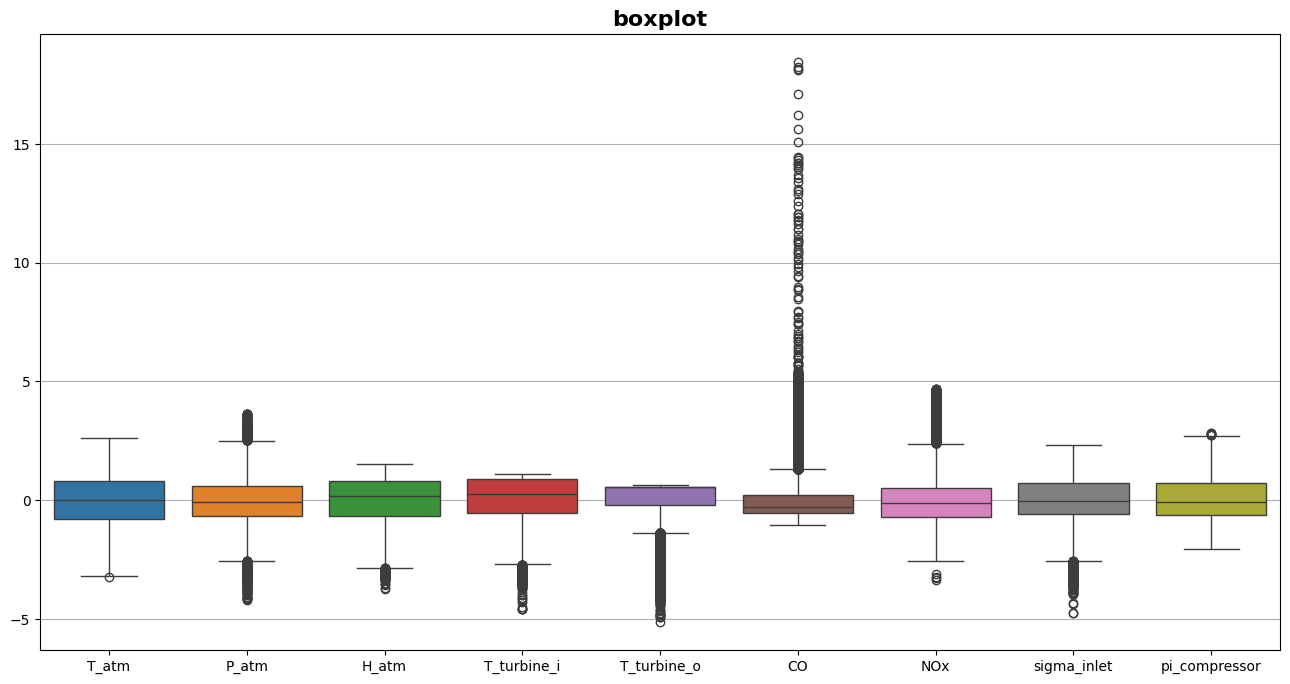

In [169]:
df.boxplot(scale=True, figsize=(16, 8), widths=1);

In [172]:
df.detect_outliers('sigma')

T_atm    P_atm   H_atm  T_turbine_i  T_turbine_o        CO      NOx  \
94     281.6358  102.110  87.738      1373.25       798.33   0.35867   63.887   
114    280.4872  102.300  80.076      1373.15       797.86   0.28478   65.495   
116    280.5518  102.260  87.673      1373.15       797.84   0.42730   66.026   
122    281.8661  102.350  77.867      1373.45       798.17   0.82869   65.856   
124    281.1043  102.370  84.187      1373.15       797.42   0.18232   63.190   
...         ...      ...     ...          ...          ...       ...      ...   
36662  284.4790  102.950  78.334      1289.85       803.83   6.31270   95.850   
36721  276.7768  102.850  93.200      1310.15       814.74  10.99300   89.172   
36722  277.3174  102.859  94.036      1310.75       815.43  11.14400   88.849   
36723  278.6320  102.850  95.219      1311.15       816.63  11.41400   96.147   
36725  279.1892  102.880  94.547      1341.05       821.38  11.98100  109.240   

       sigma_inlet  pi_compressor  
94        0.952585      14.695405  
114       0.953374      14.637517  
116       0.953487      14.644587  
122       0.953063      14.647448  
124       0.952935      14.730605  
...            ...            ...  
36662     0.972331      10.168679  
36721     0.969216      10.444014  
36722     0.968964      10.378592  
36723     0.967790      10.510643  
36725     0.962333      11.577216  

[1685 rows x 9 columns]

In [173]:
#df = df.drop(detect_outliers(df, 'sigma').index)

In [174]:
df.detect_outliers('Tukey')

T_atm    P_atm   H_atm  T_turbine_i  T_turbine_o        CO      NOx  \
11     281.1396  101.790  87.541      1367.65       807.96   0.94292   73.286   
12     283.0212  101.720  84.249      1373.35       803.73   1.04280   70.558   
13     283.8720  101.650  80.263      1373.35       802.08   1.34840   71.115   
14     284.1670  101.630  78.128      1373.25       802.21   1.06860   70.107   
15     284.0960  101.620  77.960      1373.45       803.82   0.21538   67.415   
...         ...      ...     ...          ...          ...       ...      ...   
36720  276.5276  102.850  92.703      1330.75       823.45   5.34880   66.550   
36721  276.7768  102.850  93.200      1310.15       814.74  10.99300   89.172   
36722  277.3174  102.859  94.036      1310.75       815.43  11.14400   88.849   
36723  278.6320  102.850  95.219      1311.15       816.63  11.41400   96.147   
36725  279.1892  102.880  94.547      1341.05       821.38  11.98100  109.240   

       sigma_inlet  pi_compressor  
11        0.956867      13.688982  
12        0.953811      14.356582  
13        0.953245      14.498841  
14        0.953321      14.468551  
15        0.953829      14.386953  
...            ...            ...  
36720     0.967790      10.833136  
36721     0.969216      10.444014  
36722     0.968964      10.378592  
36723     0.967790      10.510643  
36725     0.962333      11.577216  

[8231 rows x 9 columns]

In [175]:
#df = df.drop(detect_outliers(df, 'Tukey').index)

In [178]:
#df.detect_model_outliers(0.05, target='CO')

RecursionError: maximum recursion depth exceeded

## Статистика

In [26]:
df.describe().T

count         mean         std          min          25%  \
T_atm           36726.0   290.861451    7.447561   266.915200   284.929250   
P_atm           36726.0   101.307141    0.646291    98.585000   100.880000   
H_atm           36726.0    77.864274   14.461250    24.085000    68.182500   
dP_inlet        36726.0     3.925410    0.773939     2.087400     3.355525   
P_outlet_o      36726.0   255.635374   41.961568   176.980000   231.272500   
T_turbine_i     36726.0  1354.577166   17.537244  1273.950000  1344.950000   
T_turbine_o     36726.0   819.308062    6.842901   784.190000   817.870000   
A               36726.0   133.506079   15.619558   100.020000   124.450000   
P_compressor_o  36726.0  1206.046986  108.886068   985.180000  1143.400000   
CO              36726.0     2.372627    2.262856     0.000388     1.182325   
NOx             36726.0    65.296061   11.677402    25.905000    57.164250   
sigma_inlet     36726.0     0.961249    0.007651     0.924863     0.956745   
P_compressor_i  36726.0    97.381731    1.028080    92.537100    96.709225   
theta_turbine   36726.0     1.653505    0.029808     1.591837     1.634526   
pi_compressor   36726.0    12.391600    1.184466     9.973285    11.677651   
pi_turbine      36726.0     4.776480    0.370239     3.491993     4.447087   
pi_outlet       36726.0     2.523321    0.413115     1.742957     2.272856   

                        50%          75%          max  
T_atm            290.948000   296.814000   310.253000  
P_atm            101.260000   101.700000   103.659000  
H_atm             80.465500    89.373750   100.200000  
dP_inlet           3.937450     4.376800     7.610600  
P_outlet_o       251.045000   290.590000   407.160000  
T_turbine_i     1359.050000  1370.150000  1374.050000  
T_turbine_o      823.030000   823.190000   823.760000  
A                133.730000   144.080000   179.500000  
P_compressor_o  1196.500000  1285.375000  1515.900000  
CO                 1.713700     2.843350    44.103000  
NOx               63.851000    71.549000   119.910000  
sigma_inlet        0.961116     0.966889     0.979088  
P_compressor_i    97.348050    98.045275   101.052100  
theta_turbine      1.651235     1.671660     1.746477  
pi_compressor     12.295917    13.261673    15.743552  
pi_turbine         4.770135     4.998312     5.831749  
pi_outlet          2.481524     2.875784     4.043698

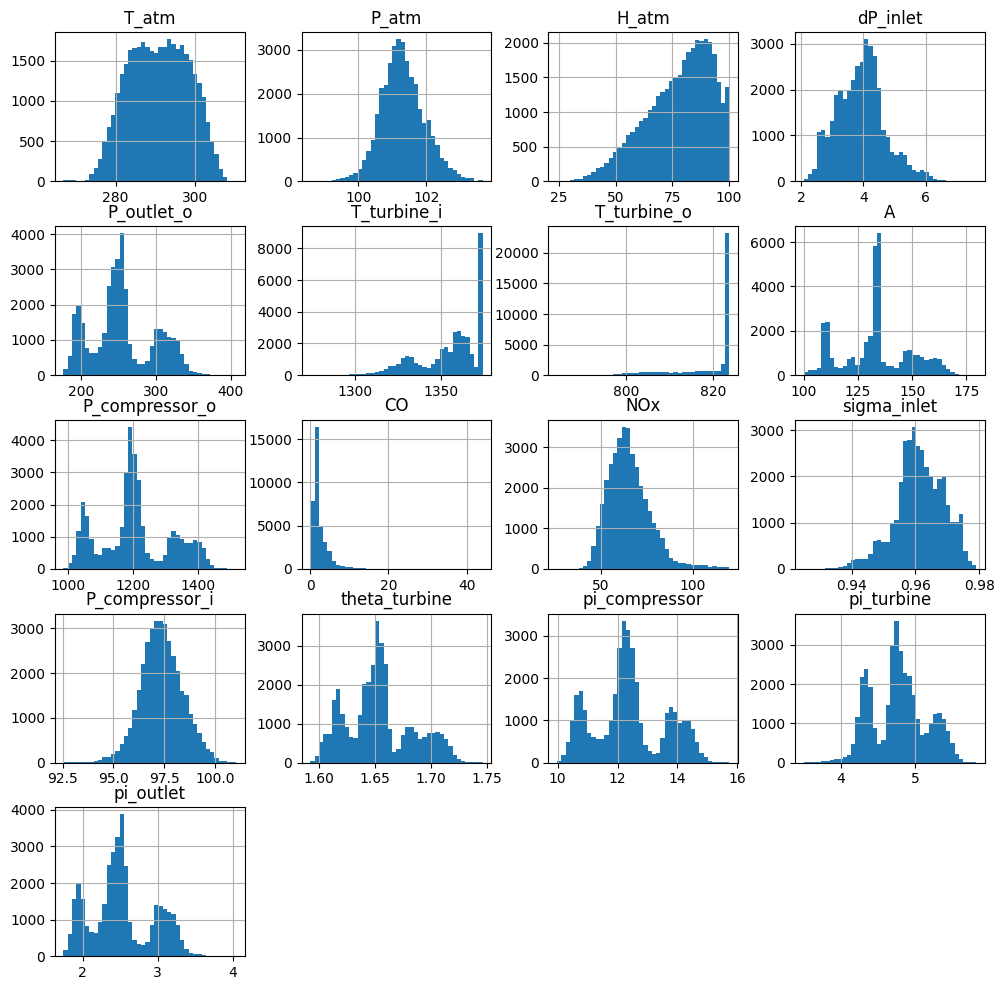

In [27]:
df.histplot()

### Корреляционный анализ

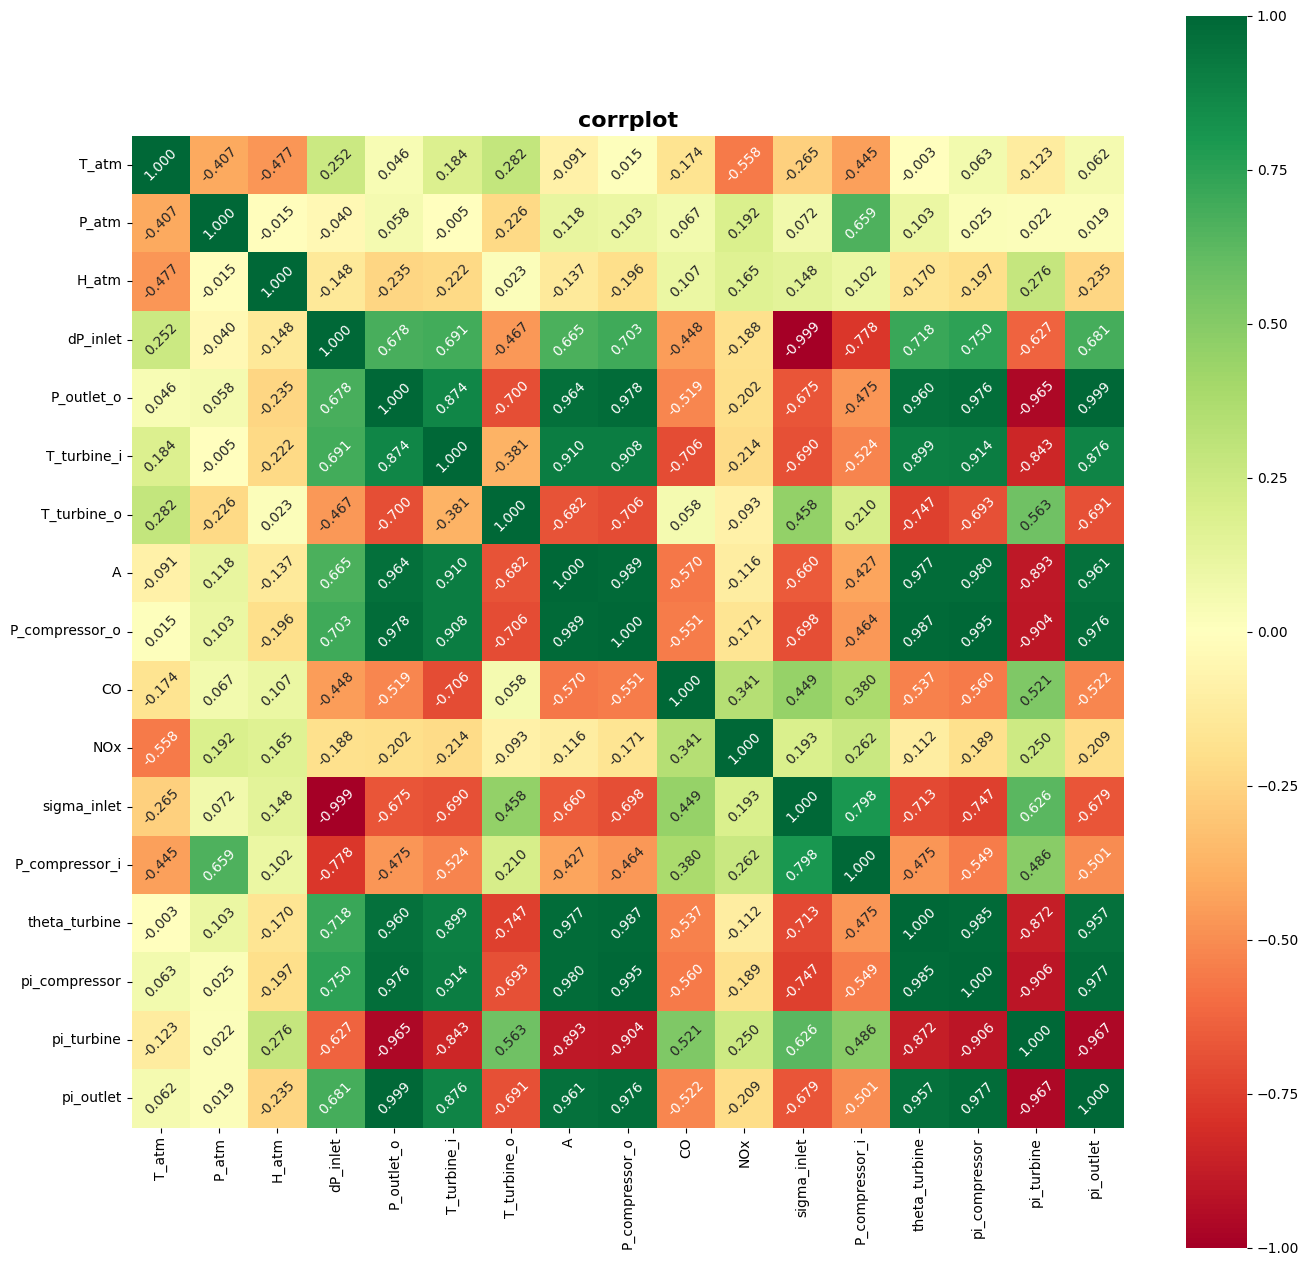

In [28]:
df.corrplot(figsize=(16, 16), fmt=3)

Удаление линейно-зависимых признаков

In [29]:
df.drop(['A', 
         'dP_inlet', 
         'P_compressor_i', 'P_compressor_o', 
         'theta_turbine', 'pi_turbine', 
         'pi_outlet', 'P_outlet_o'], 
         axis=1, inplace=True)

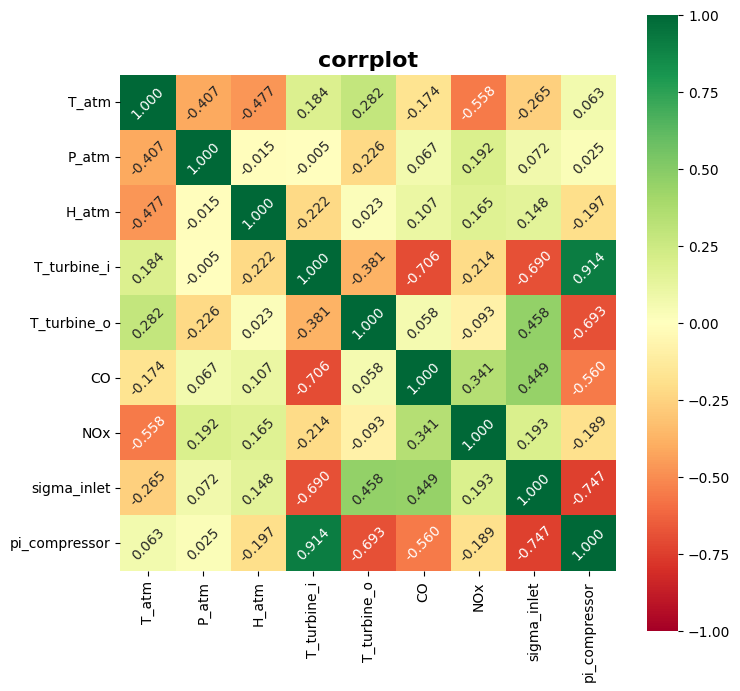

In [113]:
df.corrplot(figsize=(8, 8), fmt=3)

### Feature importance

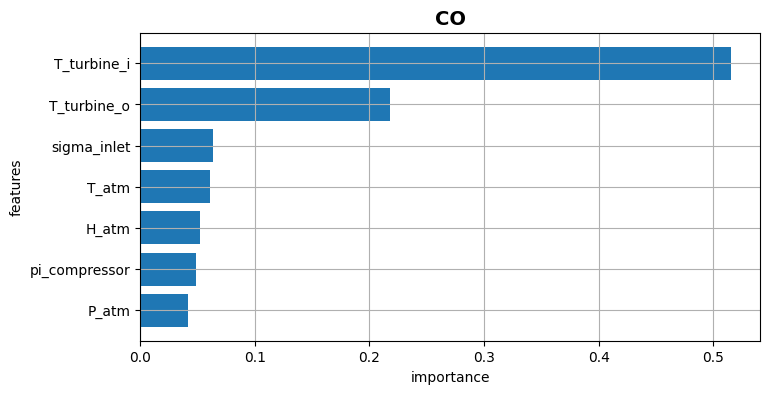

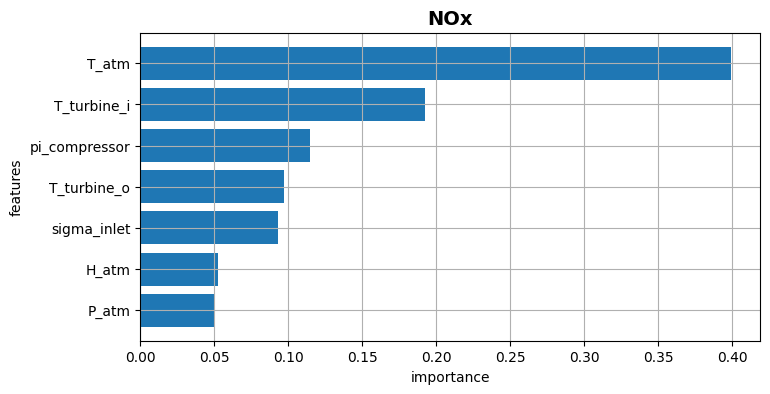

In [37]:
for target in targets:
    DataFrame(df.drop([column for column in targets if column != target], axis=1))\
        .random_forest_importance_features_plot(target=target, figsize=(8, 4))

## Экспорт обработанных данных

In [112]:
df.to_csv('datas/processed/gte_emissions.csv', sep=',', index=False)

## Preprocessing

In [128]:
test_size = 0.25
shuffle = True
random_state = 0

df_train, df_test = train_test_split(df,
                                     test_size=test_size,                                                    
                                     shuffle=shuffle,                                                    
                                     random_state=random_state)

In [129]:
print(f'train shape: {df_train.shape}')
print(f'test shape: {df_test.shape}')

train shape: (27544, 9)
test shape: (9182, 9)


## ML

In [130]:
MODELS = (LinearRegression, KNeighborsRegressor, RandomForestRegressor, GradientBoostingRegressor)

In [79]:
%%time

result_CO, result_NOx = list(), list()
for target, result in zip(('CO', 'NOx'), (result_CO, result_NOx)):
    for Model in tqdm(MODELS, desc=target):
        model = Model()
        model.fit(df_train.drop(['CO', 'NOx'], axis=1), df_train[target])
        y_pred = model.predict(df_test.drop(['CO', 'NOx'], axis=1))
        result.append({'name': model.__class__.__name__, 'model': model, 
        'r2': r2_score(df_test[target], y_pred),
        'mae': mean_absolute_error(df_test[target], y_pred), 
        'mse': mean_squared_error(df_test[target], y_pred)})
    display(pd.DataFrame(result).drop(['model'], axis=1).sort_values(by=['r2'], ascending=False))

CO: 100%|██████████| 4/4 [00:26<00:00,  6.53s/it]


name        r2       mae       mse
2      RandomForestRegressor  0.756174  0.501383  1.329721
3  GradientBoostingRegressor  0.703991  0.653383  1.614304
1        KNeighborsRegressor  0.665736  0.666238  1.822933
0           LinearRegression  0.559898  0.881689  2.400124

NOx: 100%|██████████| 4/4 [00:24<00:00,  6.03s/it]


name        r2       mae        mse
2      RandomForestRegressor  0.860550  2.869777  19.614014
3  GradientBoostingRegressor  0.729513  4.377914  38.044717
1        KNeighborsRegressor  0.715112  4.336027  40.070213
0           LinearRegression  0.478235  6.141338  73.387613

CPU times: total: 50.2 s
Wall time: 50.3 s


### GridSearchCV

In [87]:
best_models = (RandomForestRegressor(), RandomForestRegressor())

In [93]:
param_grid = {'n_estimators': list(range(25, 150 + 1, 5)),
              'max_depth': list(range(4, 20 + 1, 2)),
              'random_state': [0]}

In [94]:
%%time

for target, model in zip(('CO', 'NOx'), best_models):
    print(Fore.RED + target + Fore.RESET)

    gscv = GridSearchCV(model, param_grid=param_grid, n_jobs=-1)
    gscv.fit(df_train.drop(['CO', 'NOx'], axis=1), df_train[target])

    best_model = gscv.best_estimator_
    print(f'best estimator: {best_model}')
    print(f'best params: {gscv.best_params_}')
    for metric in (r2_score, mean_absolute_error, mean_squared_error):
        print(Fore.YELLOW + metric.__name__ + Fore.RESET)
        print('\t' + f'train: {metric(df_train[target], best_model.predict(df_train.drop(["CO", "NOx"], axis=1))):.4f}')
        print('\t' + f'test:  {metric(df_test[target], best_model.predict(df_test.drop(["CO", "NOx"], axis=1))):.4f}')
    print()
    
    with open(f'models/gte_emissions_{target}.pkl', 'wb') as file:
        pickle.dump(best_model, file)

CO
best estimator: RandomForestRegressor(max_depth=18, n_estimators=105, random_state=0)
best params: {'max_depth': 18, 'n_estimators': 105, 'random_state': 0}
r2_score
	train: 0.9542
	test:  0.7608
mean_absolute_error
	train: 0.2665
	test:  0.5048
mean_squared_error
	train: 0.2295
	test:  1.3047

NOx
best estimator: RandomForestRegressor(max_depth=20, n_estimators=150, random_state=0)
best params: {'max_depth': 20, 'n_estimators': 150, 'random_state': 0}
r2_score
	train: 0.9769
	test:  0.8616
mean_absolute_error
	train: 1.2016
	test:  2.8714
mean_squared_error
	train: 3.1232
	test:  19.4603

CPU times: total: 1min 12s
Wall time: 1h 9min 30s


## DL

In [95]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [156]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(len(df.columns)-len(targets),)))
model.add(tf.keras.layers.Normalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [157]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 7)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164 (660.00 B)

 Trainable params: 149 (596.00 B)

 Non-trainable params: 15 (64.00 B)

In [158]:
learning_rate = 0.1
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
loss = 'mse'
metrics = ['mae']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [159]:
monitor = 'loss'
min_delta = 0.01
patience = 5 

callbacks = [tf.keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             tf.keras.callbacks.ModelCheckpoint(monitor=monitor, filepath='models/model_{epoch:d}.keras', save_best_only=True, verbose=verbose),
             tf.keras.callbacks.CSVLogger('logs/log.csv', separator=",", append=False),
             tf.keras.callbacks.TerminateOnNaN()]

CO
Epoch 1/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 6.8461 - mae: 1.4944
Epoch 1: loss did not improve from 6.88678
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.8462 - mae: 1.4944 - val_loss: 7.3576 - val_mae: 1.5166
Epoch 2/100
403/431 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2795 - mae: 1.5220
Epoch 2: loss did not improve from 6.88678
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2533 - mae: 1.5204 - val_loss: 7.3576 - val_mae: 1.5166
Epoch 3/100
388/431 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5562 - mae: 1.4784
Epoch 3: loss improved from 6.88678 to 6.88678, saving model to models/model_3.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.5821 - mae: 1.4802 - val_loss: 7.3576 - val_mae: 1.5166
Epoch 4/100
420/431 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 6.8111 - mae: 1.5126
Epoch 4: loss did not improve from 6.88678
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8131 - mae: 1.5122 - val_loss: 7.3576 - val_mae: 1.5166
Epoch 5/100
373/431 ━━━

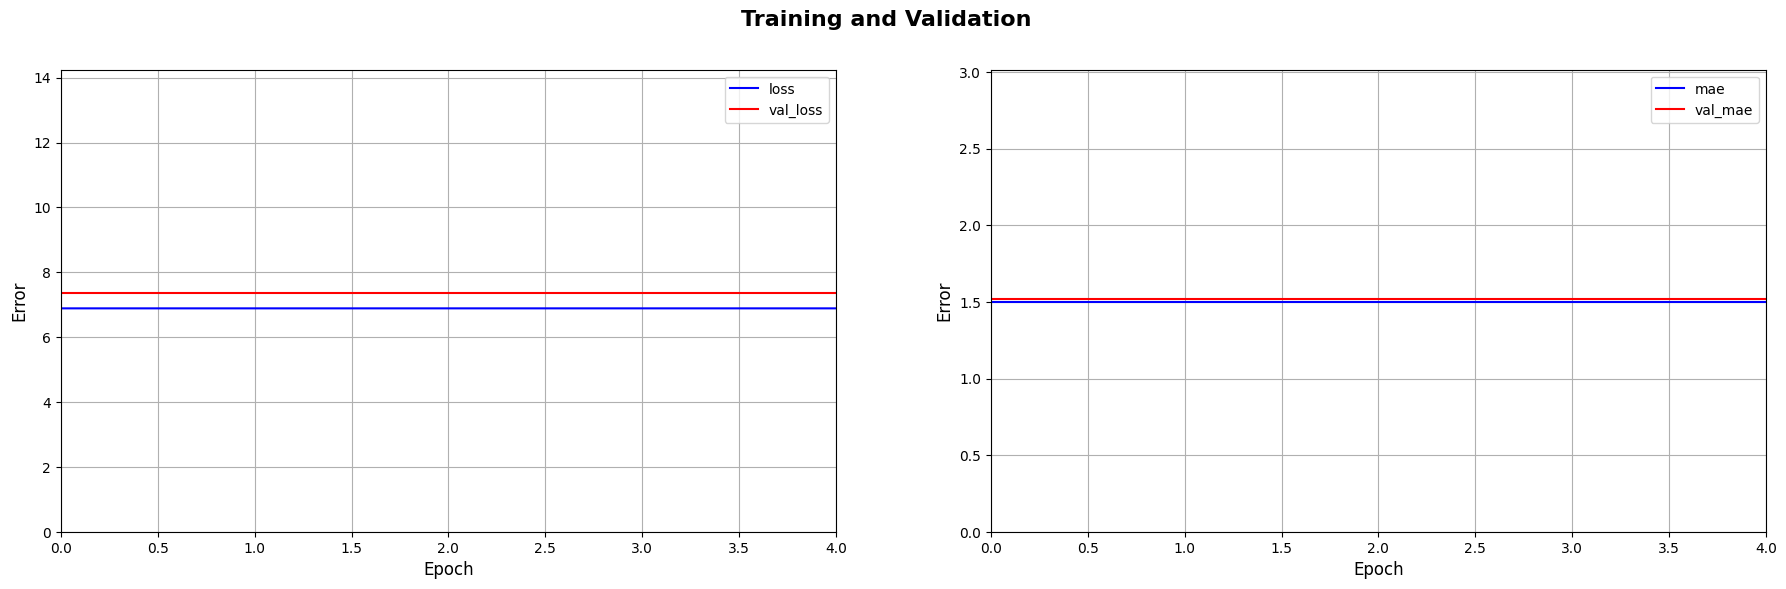

NOx
Epoch 1/100
397/431 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4281.8003 - mae: 64.3980
Epoch 1: loss did not improve from 6.88678
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4280.6079 - mae: 64.3886 - val_loss: 4285.2695 - val_mae: 64.3787
Epoch 2/100
412/431 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 4266.2891 - mae: 64.2747
Epoch 2: loss did not improve from 6.88678
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4266.2153 - mae: 64.2741 - val_loss: 4285.2695 - val_mae: 64.3787
Epoch 3/100
425/431 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4251.2178 - mae: 64.1807
Epoch 3: loss did not improve from 6.88678
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4251.4419 - mae: 64.1821 - val_loss: 4285.2695 - val_mae: 64.3787
Epoch 4/100
388/431 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 4256.1772 - mae: 64.1952
Epoch 4: loss did not improve from 6.88678
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4257.2412 - mae: 64.2034 - val_loss: 4285.2695 - val_mae: 64.3787
Epoch 5/100
428/

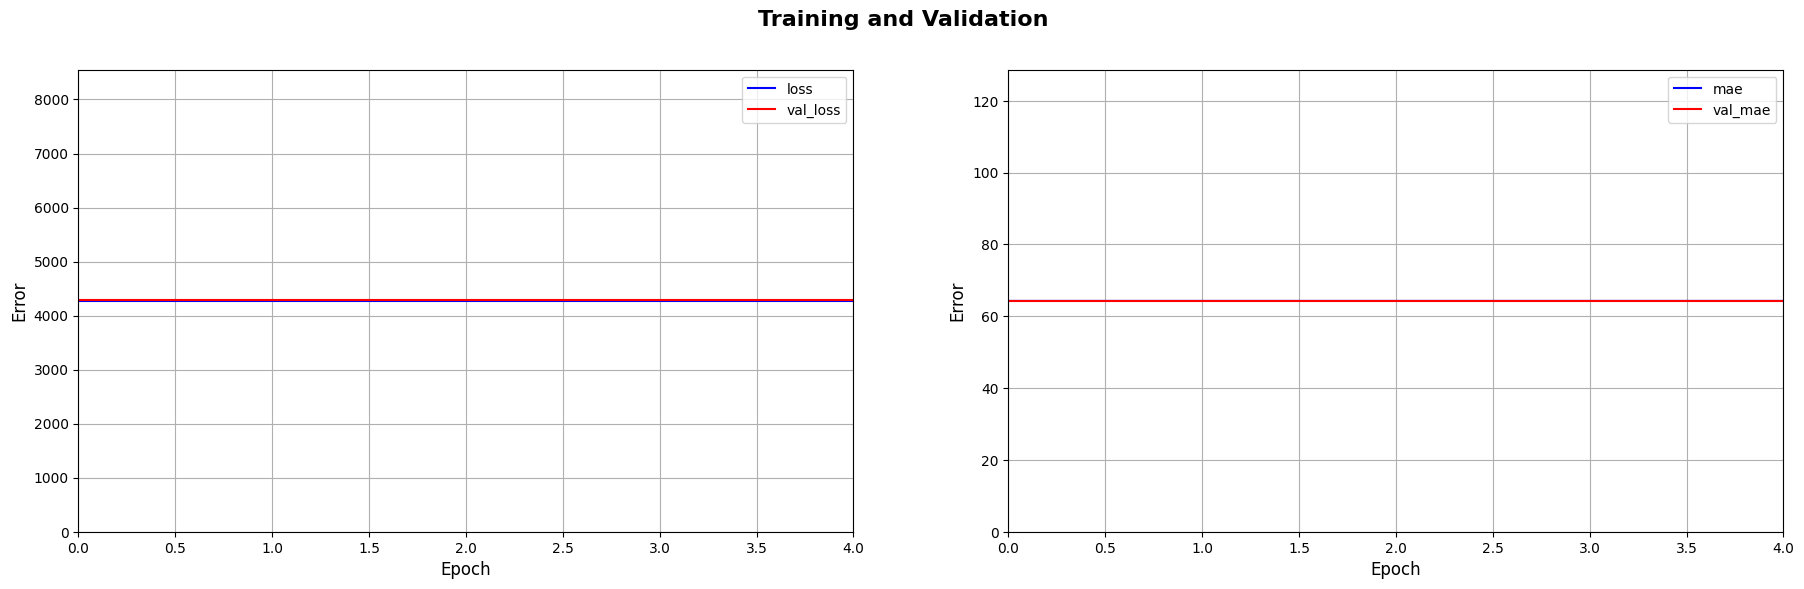

CPU times: total: 17.5 s
Wall time: 13.5 s


In [161]:
%%time

epochs = 100
batch_size = 64
verbose = True

for target in targets: 
    print(Fore.RED + target + Fore.RESET)
    history = model.fit(
        df_train.drop(['CO', 'NOx'], axis=1), df_train[target],
        epochs=epochs,
        validation_data=(df_test.drop(['CO', 'NOx'], axis=1), df_test[target]),
        #validation_split = 0.2,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose)

    for metric in (r2_score, mean_absolute_error, mean_squared_error):
        print(Fore.YELLOW + metric.__name__ + Fore.RESET)
        print('\t' + f'train: {metric(df_train[target], model.predict(df_train.drop(["CO", "NOx"], axis=1), verbose=False)):.4f}')
        print('\t' + f'test:  {metric(df_test[target], model.predict(df_test.drop(["CO", "NOx"], axis=1), verbose=False)):.4f}')
    print()

    model.save(f'models/gte_emissions_{target}.keras')
    training_plot(history, figsize=(22, 6), savefig=False)

## Тестирование

In [163]:
os.listdir('models')

['gte_emission_CO.pkl',
 'gte_emission_NOx.pkl',
 'gte_emissions_CO.keras',
 'gte_emissions_NOx.keras']